In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3,83,4,0,14,101,...,0,0,140,4,0,0,56,8,549,0
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154,0,0,1,104,3,...,2,0,48,0,0,0,102,1,0,0
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7,0,4,53,23,3,...,5,0,4,0,0,0,26,4,0,0
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16,0,0,0,4,0,...,0,0,8,0,0,0,0,0,0,0


In [3]:
X = data_df['x']
y = data_df[y_cols]

In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=64


In [5]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-05-25 22:21:07.829170: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [8]:
print(N_y)

TiteSeq_01_bin1     2579236
TiteSeq_01_bin2     1157805
TiteSeq_01_bin3     1626103
TiteSeq_01_bin4     5929980
TiteSeq_02_bin1     2676486
                     ...   
TiteSeq_15_bin4      401678
TiteSeq_16_bin1    10930706
TiteSeq_16_bin2      684127
TiteSeq_16_bin3     1299065
TiteSeq_16_bin4      254070
Length: 64, dtype: int64


#### I approximated these values from Fig 2B

In [9]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [10]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [11]:
mp_list = [mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [12]:
# there are 16 measurement processes in this 
len(mp_list)

16

In [13]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4285)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4221)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4222        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [15]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,
                       y_train[y_cols[44:48]].values,
                       y_train[y_cols[48:52]].values,
                       y_train[y_cols[52:56]].values,                   
                       y_train[y_cols[56:60]].values,                                      
                       y_train[y_cols[60:64]].values,                                                         
                      ],

               shuffle=False)

N = 74,560 observations set as training data.
Using 20.0% for validation.
Time to set data: 17.6 sec.


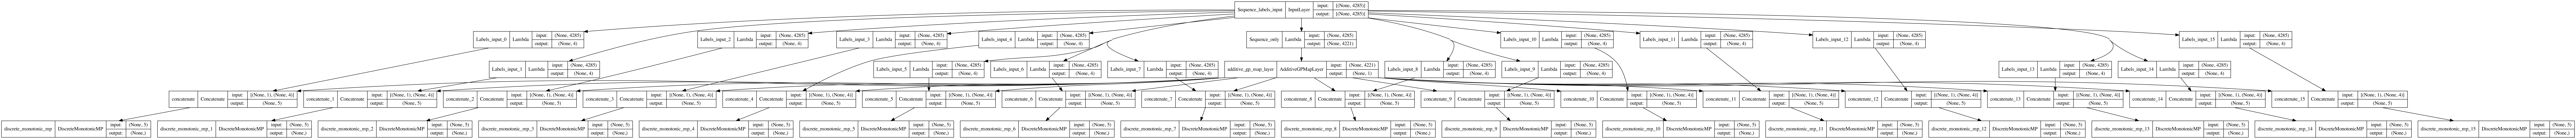

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='titeseq_dar.png')

In [17]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=300,
          batch_size=250,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/300
239/239 [==============================] - 18s 35ms/step - loss: 620795.4375 - discrete_monotonic_mp_loss: 37765.1719 - discrete_monotonic_mp_1_loss: 39662.8555 - discrete_monotonic_mp_2_loss: 40790.6602 - discrete_monotonic_mp_3_loss: 45705.0352 - discrete_monotonic_mp_4_loss: 43022.9609 - discrete_monotonic_mp_5_loss: 47192.8750 - discrete_monotonic_mp_6_loss: 44544.5781 - discrete_monotonic_mp_7_loss: 45594.7656 - discrete_monotonic_mp_8_loss: 42124.7891 - discrete_monotonic_mp_9_loss: 37801.7031 - discrete_monotonic_mp_10_loss: 41348.7188 - discrete_monotonic_mp_11_loss: 46769.1719 - discrete_monotonic_mp_12_loss: 29126.1875 - discrete_monotonic_mp_13_loss: 25435.0078 - discrete_monotonic_mp_14_loss: 24417.1660 - discrete_monotonic_mp_15_loss: 29493.9434 - I_var: -0.2691 - val_loss: 533535.6250 - val_discrete_monotonic_mp_loss: 34171.3750 - val_discrete_monotonic_mp_1_loss: 36006.8984 - val_discrete_monotonic_mp_2_loss: 37812.6758 - val_discrete_monotonic_mp_3_loss: 419

239/239 [==============================] - 5s 20ms/step - loss: 573382.5625 - discrete_monotonic_mp_loss: 37240.4922 - discrete_monotonic_mp_1_loss: 39408.2227 - discrete_monotonic_mp_2_loss: 40443.6445 - discrete_monotonic_mp_3_loss: 45426.3633 - discrete_monotonic_mp_4_loss: 42544.5352 - discrete_monotonic_mp_5_loss: 46883.7031 - discrete_monotonic_mp_6_loss: 44165.9688 - discrete_monotonic_mp_7_loss: 45045.4297 - discrete_monotonic_mp_8_loss: 41008.3086 - discrete_monotonic_mp_9_loss: 34254.8594 - discrete_monotonic_mp_10_loss: 35567.9023 - discrete_monotonic_mp_11_loss: 40713.4375 - discrete_monotonic_mp_12_loss: 20166.2734 - discrete_monotonic_mp_13_loss: 18588.3535 - discrete_monotonic_mp_14_loss: 19805.2246 - discrete_monotonic_mp_15_loss: 22119.8828 - I_var: -0.0104 - val_loss: 533382.0000 - val_discrete_monotonic_mp_loss: 34368.2773 - val_discrete_monotonic_mp_1_loss: 36211.8984 - val_discrete_monotonic_mp_2_loss: 38059.9883 - val_discrete_monotonic_mp_3_loss: 42252.4648 - val

239/239 [==============================] - 5s 21ms/step - loss: 572023.2500 - discrete_monotonic_mp_loss: 37073.7109 - discrete_monotonic_mp_1_loss: 39238.7539 - discrete_monotonic_mp_2_loss: 40281.9023 - discrete_monotonic_mp_3_loss: 45233.7578 - discrete_monotonic_mp_4_loss: 42351.9180 - discrete_monotonic_mp_5_loss: 46715.1133 - discrete_monotonic_mp_6_loss: 44034.5703 - discrete_monotonic_mp_7_loss: 44925.4805 - discrete_monotonic_mp_8_loss: 40995.9688 - discrete_monotonic_mp_9_loss: 34214.5586 - discrete_monotonic_mp_10_loss: 35528.0938 - discrete_monotonic_mp_11_loss: 40723.5742 - discrete_monotonic_mp_12_loss: 20177.8340 - discrete_monotonic_mp_13_loss: 18594.3438 - discrete_monotonic_mp_14_loss: 19808.7363 - discrete_monotonic_mp_15_loss: 22124.7402 - I_var: -0.0074 - val_loss: 537292.0625 - val_discrete_monotonic_mp_loss: 34496.2812 - val_discrete_monotonic_mp_1_loss: 36363.8594 - val_discrete_monotonic_mp_2_loss: 38138.6289 - val_discrete_monotonic_mp_3_loss: 42512.5430 - val

239/239 [==============================] - 5s 22ms/step - loss: 569820.9375 - discrete_monotonic_mp_loss: 36345.6250 - discrete_monotonic_mp_1_loss: 38524.1211 - discrete_monotonic_mp_2_loss: 39583.9883 - discrete_monotonic_mp_3_loss: 44574.4141 - discrete_monotonic_mp_4_loss: 41724.4727 - discrete_monotonic_mp_5_loss: 46220.0977 - discrete_monotonic_mp_6_loss: 43888.5859 - discrete_monotonic_mp_7_loss: 45078.9141 - discrete_monotonic_mp_8_loss: 41276.0234 - discrete_monotonic_mp_9_loss: 34539.9453 - discrete_monotonic_mp_10_loss: 35741.2148 - discrete_monotonic_mp_11_loss: 41154.5195 - discrete_monotonic_mp_12_loss: 20350.2246 - discrete_monotonic_mp_13_loss: 18728.0215 - discrete_monotonic_mp_14_loss: 19924.0117 - discrete_monotonic_mp_15_loss: 22166.8027 - I_var: -0.0124 - val_loss: 531012.6875 - val_discrete_monotonic_mp_loss: 33477.0859 - val_discrete_monotonic_mp_1_loss: 35332.8164 - val_discrete_monotonic_mp_2_loss: 37099.8633 - val_discrete_monotonic_mp_3_loss: 41355.9297 - val

239/239 [==============================] - 4s 18ms/step - loss: 554543.3125 - discrete_monotonic_mp_loss: 34085.9453 - discrete_monotonic_mp_1_loss: 36287.2305 - discrete_monotonic_mp_2_loss: 37482.5508 - discrete_monotonic_mp_3_loss: 42194.0352 - discrete_monotonic_mp_4_loss: 39634.6250 - discrete_monotonic_mp_5_loss: 44151.3828 - discrete_monotonic_mp_6_loss: 42184.9062 - discrete_monotonic_mp_7_loss: 43849.2344 - discrete_monotonic_mp_8_loss: 40853.6250 - discrete_monotonic_mp_9_loss: 34570.9453 - discrete_monotonic_mp_10_loss: 36167.1367 - discrete_monotonic_mp_11_loss: 41347.5781 - discrete_monotonic_mp_12_loss: 20525.1191 - discrete_monotonic_mp_13_loss: 18853.4590 - discrete_monotonic_mp_14_loss: 20083.8887 - discrete_monotonic_mp_15_loss: 22271.5547 - I_var: -0.0158 - val_loss: 519559.7500 - val_discrete_monotonic_mp_loss: 31870.6641 - val_discrete_monotonic_mp_1_loss: 33809.8750 - val_discrete_monotonic_mp_2_loss: 35684.4258 - val_discrete_monotonic_mp_3_loss: 39727.5312 - val

239/239 [==============================] - 5s 20ms/step - loss: 505259.9062 - discrete_monotonic_mp_loss: 29174.6875 - discrete_monotonic_mp_1_loss: 31524.0371 - discrete_monotonic_mp_2_loss: 33441.9805 - discrete_monotonic_mp_3_loss: 35941.7227 - discrete_monotonic_mp_4_loss: 33854.9258 - discrete_monotonic_mp_5_loss: 38062.5352 - discrete_monotonic_mp_6_loss: 36202.6094 - discrete_monotonic_mp_7_loss: 38284.9375 - discrete_monotonic_mp_8_loss: 37535.2031 - discrete_monotonic_mp_9_loss: 33229.8555 - discrete_monotonic_mp_10_loss: 35879.8555 - discrete_monotonic_mp_11_loss: 40041.2422 - discrete_monotonic_mp_12_loss: 20520.3652 - discrete_monotonic_mp_13_loss: 18889.2344 - discrete_monotonic_mp_14_loss: 20203.9570 - discrete_monotonic_mp_15_loss: 22472.6836 - I_var: -0.0213 - val_loss: 480286.8125 - val_discrete_monotonic_mp_loss: 27923.1152 - val_discrete_monotonic_mp_1_loss: 29925.6875 - val_discrete_monotonic_mp_2_loss: 32523.0664 - val_discrete_monotonic_mp_3_loss: 34878.1797 - val

239/239 [==============================] - 4s 18ms/step - loss: 457623.4375 - discrete_monotonic_mp_loss: 25108.9609 - discrete_monotonic_mp_1_loss: 27671.7441 - discrete_monotonic_mp_2_loss: 30578.4375 - discrete_monotonic_mp_3_loss: 30822.2734 - discrete_monotonic_mp_4_loss: 29217.4668 - discrete_monotonic_mp_5_loss: 33325.7070 - discrete_monotonic_mp_6_loss: 31718.8105 - discrete_monotonic_mp_7_loss: 33676.6562 - discrete_monotonic_mp_8_loss: 32367.4434 - discrete_monotonic_mp_9_loss: 29996.6133 - discrete_monotonic_mp_10_loss: 34070.8711 - discrete_monotonic_mp_11_loss: 38312.4688 - discrete_monotonic_mp_12_loss: 20003.4434 - discrete_monotonic_mp_13_loss: 18470.3242 - discrete_monotonic_mp_14_loss: 20006.3105 - discrete_monotonic_mp_15_loss: 22275.6875 - I_var: -0.0143 - val_loss: 442381.0000 - val_discrete_monotonic_mp_loss: 24923.3301 - val_discrete_monotonic_mp_1_loss: 27082.2754 - val_discrete_monotonic_mp_2_loss: 30189.9609 - val_discrete_monotonic_mp_3_loss: 30848.0762 - val

239/239 [==============================] - 5s 21ms/step - loss: 436830.1562 - discrete_monotonic_mp_loss: 23731.8398 - discrete_monotonic_mp_1_loss: 26408.6602 - discrete_monotonic_mp_2_loss: 29598.1953 - discrete_monotonic_mp_3_loss: 28771.3125 - discrete_monotonic_mp_4_loss: 27517.8867 - discrete_monotonic_mp_5_loss: 31279.8125 - discrete_monotonic_mp_6_loss: 29545.8105 - discrete_monotonic_mp_7_loss: 31556.4922 - discrete_monotonic_mp_8_loss: 29598.6094 - discrete_monotonic_mp_9_loss: 28023.9199 - discrete_monotonic_mp_10_loss: 33292.2852 - discrete_monotonic_mp_11_loss: 37654.5898 - discrete_monotonic_mp_12_loss: 19732.0566 - discrete_monotonic_mp_13_loss: 18176.6094 - discrete_monotonic_mp_14_loss: 19781.6348 - discrete_monotonic_mp_15_loss: 22160.2539 - I_var: -0.0089 - val_loss: 422455.1562 - val_discrete_monotonic_mp_loss: 23580.3164 - val_discrete_monotonic_mp_1_loss: 25881.8105 - val_discrete_monotonic_mp_2_loss: 29179.5723 - val_discrete_monotonic_mp_3_loss: 28979.4688 - val

239/239 [==============================] - 4s 17ms/step - loss: 425196.4062 - discrete_monotonic_mp_loss: 23069.8906 - discrete_monotonic_mp_1_loss: 25798.6328 - discrete_monotonic_mp_2_loss: 29123.1309 - discrete_monotonic_mp_3_loss: 27770.5781 - discrete_monotonic_mp_4_loss: 26745.3359 - discrete_monotonic_mp_5_loss: 30137.2852 - discrete_monotonic_mp_6_loss: 28157.0234 - discrete_monotonic_mp_7_loss: 30222.0430 - discrete_monotonic_mp_8_loss: 28120.0566 - discrete_monotonic_mp_9_loss: 26660.9023 - discrete_monotonic_mp_10_loss: 32809.8398 - discrete_monotonic_mp_11_loss: 37055.3047 - discrete_monotonic_mp_12_loss: 19600.6953 - discrete_monotonic_mp_13_loss: 18076.0391 - discrete_monotonic_mp_14_loss: 19706.3691 - discrete_monotonic_mp_15_loss: 22143.1543 - I_var: -0.0107 - val_loss: 412612.8438 - val_discrete_monotonic_mp_loss: 22909.5234 - val_discrete_monotonic_mp_1_loss: 25276.1016 - val_discrete_monotonic_mp_2_loss: 28728.1250 - val_discrete_monotonic_mp_3_loss: 28161.0801 - val

239/239 [==============================] - 6s 23ms/step - loss: 420049.3750 - discrete_monotonic_mp_loss: 22780.2109 - discrete_monotonic_mp_1_loss: 25526.7383 - discrete_monotonic_mp_2_loss: 28901.0098 - discrete_monotonic_mp_3_loss: 27373.8418 - discrete_monotonic_mp_4_loss: 26386.4023 - discrete_monotonic_mp_5_loss: 29769.1094 - discrete_monotonic_mp_6_loss: 27675.5801 - discrete_monotonic_mp_7_loss: 29677.4141 - discrete_monotonic_mp_8_loss: 27500.7676 - discrete_monotonic_mp_9_loss: 25948.1816 - discrete_monotonic_mp_10_loss: 32510.5488 - discrete_monotonic_mp_11_loss: 36662.2852 - discrete_monotonic_mp_12_loss: 19533.0488 - discrete_monotonic_mp_13_loss: 18034.9863 - discrete_monotonic_mp_14_loss: 19631.7500 - discrete_monotonic_mp_15_loss: 22137.1543 - I_var: -0.0071 - val_loss: 403246.8750 - val_discrete_monotonic_mp_loss: 22210.0801 - val_discrete_monotonic_mp_1_loss: 24576.7852 - val_discrete_monotonic_mp_2_loss: 28141.0293 - val_discrete_monotonic_mp_3_loss: 27127.0176 - val

239/239 [==============================] - 4s 17ms/step - loss: 415567.2812 - discrete_monotonic_mp_loss: 22577.5469 - discrete_monotonic_mp_1_loss: 25300.2539 - discrete_monotonic_mp_2_loss: 28722.9863 - discrete_monotonic_mp_3_loss: 27068.1387 - discrete_monotonic_mp_4_loss: 26098.7559 - discrete_monotonic_mp_5_loss: 29471.6465 - discrete_monotonic_mp_6_loss: 27296.6211 - discrete_monotonic_mp_7_loss: 29175.2148 - discrete_monotonic_mp_8_loss: 26884.0039 - discrete_monotonic_mp_9_loss: 25371.9023 - discrete_monotonic_mp_10_loss: 32201.4668 - discrete_monotonic_mp_11_loss: 36229.5352 - discrete_monotonic_mp_12_loss: 19451.5391 - discrete_monotonic_mp_13_loss: 18008.9551 - discrete_monotonic_mp_14_loss: 19579.6953 - discrete_monotonic_mp_15_loss: 22128.9023 - I_var: -0.0119 - val_loss: 399096.8125 - val_discrete_monotonic_mp_loss: 21993.8633 - val_discrete_monotonic_mp_1_loss: 24345.6191 - val_discrete_monotonic_mp_2_loss: 28013.0469 - val_discrete_monotonic_mp_3_loss: 26868.0898 - val

239/239 [==============================] - 4s 16ms/step - loss: 412131.1562 - discrete_monotonic_mp_loss: 22426.6328 - discrete_monotonic_mp_1_loss: 25097.7188 - discrete_monotonic_mp_2_loss: 28583.5586 - discrete_monotonic_mp_3_loss: 26852.0859 - discrete_monotonic_mp_4_loss: 25865.1895 - discrete_monotonic_mp_5_loss: 29280.7168 - discrete_monotonic_mp_6_loss: 27092.3867 - discrete_monotonic_mp_7_loss: 28831.8184 - discrete_monotonic_mp_8_loss: 26352.4707 - discrete_monotonic_mp_9_loss: 24983.7285 - discrete_monotonic_mp_10_loss: 31873.0859 - discrete_monotonic_mp_11_loss: 35833.8359 - discrete_monotonic_mp_12_loss: 19397.4141 - discrete_monotonic_mp_13_loss: 17984.4531 - discrete_monotonic_mp_14_loss: 19544.8906 - discrete_monotonic_mp_15_loss: 22130.7559 - I_var: -0.0045 - val_loss: 403160.2812 - val_discrete_monotonic_mp_loss: 22395.9297 - val_discrete_monotonic_mp_1_loss: 24651.4883 - val_discrete_monotonic_mp_2_loss: 28325.3516 - val_discrete_monotonic_mp_3_loss: 27487.3906 - val

239/239 [==============================] - 4s 16ms/step - loss: 406577.0625 - discrete_monotonic_mp_loss: 22145.0117 - discrete_monotonic_mp_1_loss: 24748.7207 - discrete_monotonic_mp_2_loss: 28347.5293 - discrete_monotonic_mp_3_loss: 26438.2363 - discrete_monotonic_mp_4_loss: 25439.3516 - discrete_monotonic_mp_5_loss: 28855.5176 - discrete_monotonic_mp_6_loss: 26597.4395 - discrete_monotonic_mp_7_loss: 28225.3828 - discrete_monotonic_mp_8_loss: 25569.4160 - discrete_monotonic_mp_9_loss: 24461.4785 - discrete_monotonic_mp_10_loss: 31544.2891 - discrete_monotonic_mp_11_loss: 35298.3242 - discrete_monotonic_mp_12_loss: 19323.0352 - discrete_monotonic_mp_13_loss: 17958.6895 - discrete_monotonic_mp_14_loss: 19504.3770 - discrete_monotonic_mp_15_loss: 22119.8418 - I_var: -0.0097 - val_loss: 389273.3438 - val_discrete_monotonic_mp_loss: 21319.0547 - val_discrete_monotonic_mp_1_loss: 23543.0449 - val_discrete_monotonic_mp_2_loss: 27454.9844 - val_discrete_monotonic_mp_3_loss: 25932.8320 - val

239/239 [==============================] - 4s 17ms/step - loss: 404281.7188 - discrete_monotonic_mp_loss: 22006.6230 - discrete_monotonic_mp_1_loss: 24488.4883 - discrete_monotonic_mp_2_loss: 28207.6543 - discrete_monotonic_mp_3_loss: 26233.3047 - discrete_monotonic_mp_4_loss: 25159.0996 - discrete_monotonic_mp_5_loss: 28709.3887 - discrete_monotonic_mp_6_loss: 26466.1426 - discrete_monotonic_mp_7_loss: 27963.8398 - discrete_monotonic_mp_8_loss: 25281.3828 - discrete_monotonic_mp_9_loss: 24404.8359 - discrete_monotonic_mp_10_loss: 31432.1621 - discrete_monotonic_mp_11_loss: 35080.9648 - discrete_monotonic_mp_12_loss: 19291.7559 - discrete_monotonic_mp_13_loss: 17954.7031 - discrete_monotonic_mp_14_loss: 19490.0859 - discrete_monotonic_mp_15_loss: 22110.7266 - I_var: -0.0068 - val_loss: 385369.5000 - val_discrete_monotonic_mp_loss: 21033.0703 - val_discrete_monotonic_mp_1_loss: 23131.8770 - val_discrete_monotonic_mp_2_loss: 27187.8086 - val_discrete_monotonic_mp_3_loss: 25542.4863 - val

239/239 [==============================] - 4s 17ms/step - loss: 397115.3438 - discrete_monotonic_mp_loss: 21478.2129 - discrete_monotonic_mp_1_loss: 23804.6016 - discrete_monotonic_mp_2_loss: 27703.0586 - discrete_monotonic_mp_3_loss: 25508.4102 - discrete_monotonic_mp_4_loss: 24395.9043 - discrete_monotonic_mp_5_loss: 28024.1270 - discrete_monotonic_mp_6_loss: 25764.0820 - discrete_monotonic_mp_7_loss: 27231.3262 - discrete_monotonic_mp_8_loss: 24618.2305 - discrete_monotonic_mp_9_loss: 23985.2695 - discrete_monotonic_mp_10_loss: 31199.8652 - discrete_monotonic_mp_11_loss: 34666.8125 - discrete_monotonic_mp_12_loss: 19233.8574 - discrete_monotonic_mp_13_loss: 17930.3320 - discrete_monotonic_mp_14_loss: 19454.1680 - discrete_monotonic_mp_15_loss: 22116.4863 - I_var: -0.0047 - val_loss: 380762.6875 - val_discrete_monotonic_mp_loss: 20773.3516 - val_discrete_monotonic_mp_1_loss: 22702.8535 - val_discrete_monotonic_mp_2_loss: 26899.0703 - val_discrete_monotonic_mp_3_loss: 25107.0547 - val

239/239 [==============================] - 4s 17ms/step - loss: 393477.0000 - discrete_monotonic_mp_loss: 21222.2891 - discrete_monotonic_mp_1_loss: 23338.8633 - discrete_monotonic_mp_2_loss: 27369.8145 - discrete_monotonic_mp_3_loss: 25134.7598 - discrete_monotonic_mp_4_loss: 23873.6660 - discrete_monotonic_mp_5_loss: 27614.9395 - discrete_monotonic_mp_6_loss: 25422.9043 - discrete_monotonic_mp_7_loss: 26835.9199 - discrete_monotonic_mp_8_loss: 24340.5293 - discrete_monotonic_mp_9_loss: 23878.2773 - discrete_monotonic_mp_10_loss: 31170.2520 - discrete_monotonic_mp_11_loss: 34555.4258 - discrete_monotonic_mp_12_loss: 19222.6660 - discrete_monotonic_mp_13_loss: 17928.3828 - discrete_monotonic_mp_14_loss: 19458.1504 - discrete_monotonic_mp_15_loss: 22109.5430 - I_var: -0.0091 - val_loss: 382336.1562 - val_discrete_monotonic_mp_loss: 20844.2441 - val_discrete_monotonic_mp_1_loss: 22543.6895 - val_discrete_monotonic_mp_2_loss: 26772.3711 - val_discrete_monotonic_mp_3_loss: 25240.4590 - val

239/239 [==============================] - 4s 18ms/step - loss: 390754.2188 - discrete_monotonic_mp_loss: 20917.4590 - discrete_monotonic_mp_1_loss: 22832.7461 - discrete_monotonic_mp_2_loss: 26947.3750 - discrete_monotonic_mp_3_loss: 24775.5352 - discrete_monotonic_mp_4_loss: 23364.0977 - discrete_monotonic_mp_5_loss: 27172.4434 - discrete_monotonic_mp_6_loss: 25174.2363 - discrete_monotonic_mp_7_loss: 26733.5391 - discrete_monotonic_mp_8_loss: 24374.2051 - discrete_monotonic_mp_9_loss: 23965.7051 - discrete_monotonic_mp_10_loss: 31216.5352 - discrete_monotonic_mp_11_loss: 34577.5039 - discrete_monotonic_mp_12_loss: 19213.0586 - discrete_monotonic_mp_13_loss: 17923.1699 - discrete_monotonic_mp_14_loss: 19451.7773 - discrete_monotonic_mp_15_loss: 22114.2012 - I_var: -0.0053 - val_loss: 371868.4062 - val_discrete_monotonic_mp_loss: 19995.7773 - val_discrete_monotonic_mp_1_loss: 21530.1387 - val_discrete_monotonic_mp_2_loss: 25940.4277 - val_discrete_monotonic_mp_3_loss: 24136.5859 - val

239/239 [==============================] - 4s 18ms/step - loss: 384282.5312 - discrete_monotonic_mp_loss: 20422.4941 - discrete_monotonic_mp_1_loss: 22140.1562 - discrete_monotonic_mp_2_loss: 26425.7520 - discrete_monotonic_mp_3_loss: 24176.2930 - discrete_monotonic_mp_4_loss: 22692.3887 - discrete_monotonic_mp_5_loss: 26336.9375 - discrete_monotonic_mp_6_loss: 24543.5410 - discrete_monotonic_mp_7_loss: 26178.5039 - discrete_monotonic_mp_8_loss: 23830.3125 - discrete_monotonic_mp_9_loss: 23635.0840 - discrete_monotonic_mp_10_loss: 31006.0020 - discrete_monotonic_mp_11_loss: 34270.1094 - discrete_monotonic_mp_12_loss: 19173.4941 - discrete_monotonic_mp_13_loss: 17908.0742 - discrete_monotonic_mp_14_loss: 19422.5723 - discrete_monotonic_mp_15_loss: 22120.1543 - I_var: -0.0128 - val_loss: 367732.4688 - val_discrete_monotonic_mp_loss: 19587.7812 - val_discrete_monotonic_mp_1_loss: 20995.3652 - val_discrete_monotonic_mp_2_loss: 25531.3398 - val_discrete_monotonic_mp_3_loss: 23742.5703 - val

239/239 [==============================] - 5s 22ms/step - loss: 380851.7500 - discrete_monotonic_mp_loss: 20053.0078 - discrete_monotonic_mp_1_loss: 21652.4551 - discrete_monotonic_mp_2_loss: 26033.1270 - discrete_monotonic_mp_3_loss: 23814.0430 - discrete_monotonic_mp_4_loss: 22336.8926 - discrete_monotonic_mp_5_loss: 25625.3379 - discrete_monotonic_mp_6_loss: 24167.7090 - discrete_monotonic_mp_7_loss: 26058.7285 - discrete_monotonic_mp_8_loss: 23696.4648 - discrete_monotonic_mp_9_loss: 23591.9824 - discrete_monotonic_mp_10_loss: 30972.8789 - discrete_monotonic_mp_11_loss: 34226.2188 - discrete_monotonic_mp_12_loss: 19162.7344 - discrete_monotonic_mp_13_loss: 17914.2949 - discrete_monotonic_mp_14_loss: 19423.5820 - discrete_monotonic_mp_15_loss: 22121.5625 - I_var: -0.0072 - val_loss: 365932.1250 - val_discrete_monotonic_mp_loss: 19447.3418 - val_discrete_monotonic_mp_1_loss: 20768.8008 - val_discrete_monotonic_mp_2_loss: 25365.6270 - val_discrete_monotonic_mp_3_loss: 23579.9922 - val

239/239 [==============================] - 4s 16ms/step - loss: 378083.4375 - discrete_monotonic_mp_loss: 19723.6738 - discrete_monotonic_mp_1_loss: 21287.2539 - discrete_monotonic_mp_2_loss: 25731.2441 - discrete_monotonic_mp_3_loss: 23411.5703 - discrete_monotonic_mp_4_loss: 22020.5430 - discrete_monotonic_mp_5_loss: 25049.0020 - discrete_monotonic_mp_6_loss: 23867.5137 - discrete_monotonic_mp_7_loss: 26001.7344 - discrete_monotonic_mp_8_loss: 23582.8809 - discrete_monotonic_mp_9_loss: 23600.9102 - discrete_monotonic_mp_10_loss: 30986.5664 - discrete_monotonic_mp_11_loss: 34195.4023 - discrete_monotonic_mp_12_loss: 19170.4707 - discrete_monotonic_mp_13_loss: 17911.6406 - discrete_monotonic_mp_14_loss: 19423.8477 - discrete_monotonic_mp_15_loss: 22118.4414 - I_var: -0.0063 - val_loss: 362046.3750 - val_discrete_monotonic_mp_loss: 18945.1250 - val_discrete_monotonic_mp_1_loss: 20197.2852 - val_discrete_monotonic_mp_2_loss: 24862.7441 - val_discrete_monotonic_mp_3_loss: 22928.2266 - val

239/239 [==============================] - 4s 16ms/step - loss: 375452.7812 - discrete_monotonic_mp_loss: 19426.8340 - discrete_monotonic_mp_1_loss: 21005.5566 - discrete_monotonic_mp_2_loss: 25472.6465 - discrete_monotonic_mp_3_loss: 23081.3223 - discrete_monotonic_mp_4_loss: 21744.3965 - discrete_monotonic_mp_5_loss: 24652.5508 - discrete_monotonic_mp_6_loss: 23648.8672 - discrete_monotonic_mp_7_loss: 25914.6289 - discrete_monotonic_mp_8_loss: 23451.1289 - discrete_monotonic_mp_9_loss: 23515.8535 - discrete_monotonic_mp_10_loss: 30899.2207 - discrete_monotonic_mp_11_loss: 34096.1914 - discrete_monotonic_mp_12_loss: 19136.5820 - discrete_monotonic_mp_13_loss: 17896.8477 - discrete_monotonic_mp_14_loss: 19403.7090 - discrete_monotonic_mp_15_loss: 22105.6133 - I_var: -0.0048 - val_loss: 360186.7188 - val_discrete_monotonic_mp_loss: 18713.1699 - val_discrete_monotonic_mp_1_loss: 20013.5488 - val_discrete_monotonic_mp_2_loss: 24677.2969 - val_discrete_monotonic_mp_3_loss: 22751.4102 - val

239/239 [==============================] - 4s 17ms/step - loss: 374211.7812 - discrete_monotonic_mp_loss: 19263.3164 - discrete_monotonic_mp_1_loss: 20866.4902 - discrete_monotonic_mp_2_loss: 25306.1074 - discrete_monotonic_mp_3_loss: 22876.9258 - discrete_monotonic_mp_4_loss: 21592.7168 - discrete_monotonic_mp_5_loss: 24450.5547 - discrete_monotonic_mp_6_loss: 23536.1348 - discrete_monotonic_mp_7_loss: 25944.1777 - discrete_monotonic_mp_8_loss: 23419.8125 - discrete_monotonic_mp_9_loss: 23527.1504 - discrete_monotonic_mp_10_loss: 30889.1660 - discrete_monotonic_mp_11_loss: 34064.0195 - discrete_monotonic_mp_12_loss: 19115.0254 - discrete_monotonic_mp_13_loss: 17884.4277 - discrete_monotonic_mp_14_loss: 19377.7285 - discrete_monotonic_mp_15_loss: 22097.2344 - I_var: -0.0073 - val_loss: 359702.0000 - val_discrete_monotonic_mp_loss: 18652.4512 - val_discrete_monotonic_mp_1_loss: 19957.5859 - val_discrete_monotonic_mp_2_loss: 24583.6309 - val_discrete_monotonic_mp_3_loss: 22659.9414 - val

239/239 [==============================] - 6s 27ms/step - loss: 374117.0625 - discrete_monotonic_mp_loss: 19167.9727 - discrete_monotonic_mp_1_loss: 20774.0723 - discrete_monotonic_mp_2_loss: 25222.7617 - discrete_monotonic_mp_3_loss: 22784.8809 - discrete_monotonic_mp_4_loss: 21496.9570 - discrete_monotonic_mp_5_loss: 24461.1211 - discrete_monotonic_mp_6_loss: 23564.6973 - discrete_monotonic_mp_7_loss: 26035.6309 - discrete_monotonic_mp_8_loss: 23503.4727 - discrete_monotonic_mp_9_loss: 23581.1523 - discrete_monotonic_mp_10_loss: 30870.4941 - discrete_monotonic_mp_11_loss: 34096.7148 - discrete_monotonic_mp_12_loss: 19142.4570 - discrete_monotonic_mp_13_loss: 17902.9453 - discrete_monotonic_mp_14_loss: 19399.2676 - discrete_monotonic_mp_15_loss: 22111.4258 - I_var: -0.0089 - val_loss: 359641.8125 - val_discrete_monotonic_mp_loss: 18614.9453 - val_discrete_monotonic_mp_1_loss: 19914.6855 - val_discrete_monotonic_mp_2_loss: 24559.3789 - val_discrete_monotonic_mp_3_loss: 22541.0273 - val

239/239 [==============================] - 5s 22ms/step - loss: 372557.9062 - discrete_monotonic_mp_loss: 19088.8906 - discrete_monotonic_mp_1_loss: 20693.0332 - discrete_monotonic_mp_2_loss: 25130.4785 - discrete_monotonic_mp_3_loss: 22693.6152 - discrete_monotonic_mp_4_loss: 21417.7930 - discrete_monotonic_mp_5_loss: 24187.7168 - discrete_monotonic_mp_6_loss: 23306.8340 - discrete_monotonic_mp_7_loss: 25897.2207 - discrete_monotonic_mp_8_loss: 23277.2949 - discrete_monotonic_mp_9_loss: 23503.5449 - discrete_monotonic_mp_10_loss: 30829.2480 - discrete_monotonic_mp_11_loss: 34041.6172 - discrete_monotonic_mp_12_loss: 19119.4492 - discrete_monotonic_mp_13_loss: 17888.8184 - discrete_monotonic_mp_14_loss: 19383.2285 - discrete_monotonic_mp_15_loss: 22098.2207 - I_var: -0.0111 - val_loss: 361938.9062 - val_discrete_monotonic_mp_loss: 18742.5215 - val_discrete_monotonic_mp_1_loss: 20076.3828 - val_discrete_monotonic_mp_2_loss: 24683.9414 - val_discrete_monotonic_mp_3_loss: 22827.1836 - val

239/239 [==============================] - 5s 19ms/step - loss: 371920.0625 - discrete_monotonic_mp_loss: 19024.5371 - discrete_monotonic_mp_1_loss: 20624.1797 - discrete_monotonic_mp_2_loss: 25074.2129 - discrete_monotonic_mp_3_loss: 22600.4238 - discrete_monotonic_mp_4_loss: 21327.8496 - discrete_monotonic_mp_5_loss: 24103.5977 - discrete_monotonic_mp_6_loss: 23235.3301 - discrete_monotonic_mp_7_loss: 25874.1719 - discrete_monotonic_mp_8_loss: 23228.7422 - discrete_monotonic_mp_9_loss: 23486.3945 - discrete_monotonic_mp_10_loss: 30794.0156 - discrete_monotonic_mp_11_loss: 34033.9141 - discrete_monotonic_mp_12_loss: 19122.7754 - discrete_monotonic_mp_13_loss: 17892.3789 - discrete_monotonic_mp_14_loss: 19399.7910 - discrete_monotonic_mp_15_loss: 22096.6230 - I_var: -0.0061 - val_loss: 357168.0938 - val_discrete_monotonic_mp_loss: 18415.5488 - val_discrete_monotonic_mp_1_loss: 19719.1309 - val_discrete_monotonic_mp_2_loss: 24373.3418 - val_discrete_monotonic_mp_3_loss: 22388.4082 - val

239/239 [==============================] - 4s 19ms/step - loss: 372028.6562 - discrete_monotonic_mp_loss: 19039.2461 - discrete_monotonic_mp_1_loss: 20641.1367 - discrete_monotonic_mp_2_loss: 25093.1797 - discrete_monotonic_mp_3_loss: 22619.9766 - discrete_monotonic_mp_4_loss: 21343.5137 - discrete_monotonic_mp_5_loss: 24090.7480 - discrete_monotonic_mp_6_loss: 23179.9355 - discrete_monotonic_mp_7_loss: 25881.6035 - discrete_monotonic_mp_8_loss: 23204.7402 - discrete_monotonic_mp_9_loss: 23519.1348 - discrete_monotonic_mp_10_loss: 30809.2422 - discrete_monotonic_mp_11_loss: 34053.1484 - discrete_monotonic_mp_12_loss: 19129.2227 - discrete_monotonic_mp_13_loss: 17902.8223 - discrete_monotonic_mp_14_loss: 19398.7969 - discrete_monotonic_mp_15_loss: 22121.1230 - I_var: -0.0073 - val_loss: 357384.7500 - val_discrete_monotonic_mp_loss: 18413.9824 - val_discrete_monotonic_mp_1_loss: 19683.6387 - val_discrete_monotonic_mp_2_loss: 24367.9707 - val_discrete_monotonic_mp_3_loss: 22340.9766 - val

239/239 [==============================] - 4s 19ms/step - loss: 371213.9375 - discrete_monotonic_mp_loss: 18947.3379 - discrete_monotonic_mp_1_loss: 20535.2441 - discrete_monotonic_mp_2_loss: 24995.3066 - discrete_monotonic_mp_3_loss: 22508.8789 - discrete_monotonic_mp_4_loss: 21233.6465 - discrete_monotonic_mp_5_loss: 24027.9863 - discrete_monotonic_mp_6_loss: 23119.3320 - discrete_monotonic_mp_7_loss: 25887.2598 - discrete_monotonic_mp_8_loss: 23201.0469 - discrete_monotonic_mp_9_loss: 23511.0098 - discrete_monotonic_mp_10_loss: 30773.8418 - discrete_monotonic_mp_11_loss: 34014.7852 - discrete_monotonic_mp_12_loss: 19111.6719 - discrete_monotonic_mp_13_loss: 17886.4297 - discrete_monotonic_mp_14_loss: 19373.0840 - discrete_monotonic_mp_15_loss: 22085.8398 - I_var: -0.0042 - val_loss: 357378.2500 - val_discrete_monotonic_mp_loss: 18425.0176 - val_discrete_monotonic_mp_1_loss: 19752.5664 - val_discrete_monotonic_mp_2_loss: 24395.3750 - val_discrete_monotonic_mp_3_loss: 22438.4004 - val

239/239 [==============================] - 4s 19ms/step - loss: 370891.2188 - discrete_monotonic_mp_loss: 18927.4961 - discrete_monotonic_mp_1_loss: 20526.6504 - discrete_monotonic_mp_2_loss: 24976.3867 - discrete_monotonic_mp_3_loss: 22496.5215 - discrete_monotonic_mp_4_loss: 21212.3672 - discrete_monotonic_mp_5_loss: 23997.4688 - discrete_monotonic_mp_6_loss: 23074.6035 - discrete_monotonic_mp_7_loss: 25869.4121 - discrete_monotonic_mp_8_loss: 23135.3398 - discrete_monotonic_mp_9_loss: 23483.3828 - discrete_monotonic_mp_10_loss: 30737.8438 - discrete_monotonic_mp_11_loss: 34003.4453 - discrete_monotonic_mp_12_loss: 19101.5254 - discrete_monotonic_mp_13_loss: 17879.8887 - discrete_monotonic_mp_14_loss: 19366.6309 - discrete_monotonic_mp_15_loss: 22101.1250 - I_var: -0.0067 - val_loss: 356042.3750 - val_discrete_monotonic_mp_loss: 18281.8535 - val_discrete_monotonic_mp_1_loss: 19571.1914 - val_discrete_monotonic_mp_2_loss: 24262.0137 - val_discrete_monotonic_mp_3_loss: 22201.6836 - val

239/239 [==============================] - 5s 19ms/step - loss: 371102.8125 - discrete_monotonic_mp_loss: 18925.6055 - discrete_monotonic_mp_1_loss: 20525.9023 - discrete_monotonic_mp_2_loss: 24987.0996 - discrete_monotonic_mp_3_loss: 22497.4746 - discrete_monotonic_mp_4_loss: 21207.4805 - discrete_monotonic_mp_5_loss: 24052.7559 - discrete_monotonic_mp_6_loss: 23119.8906 - discrete_monotonic_mp_7_loss: 25899.8281 - discrete_monotonic_mp_8_loss: 23179.9629 - discrete_monotonic_mp_9_loss: 23503.5938 - discrete_monotonic_mp_10_loss: 30718.1387 - discrete_monotonic_mp_11_loss: 34012.9492 - discrete_monotonic_mp_12_loss: 19105.4199 - discrete_monotonic_mp_13_loss: 17886.1445 - discrete_monotonic_mp_14_loss: 19385.2129 - discrete_monotonic_mp_15_loss: 22094.1719 - I_var: -0.0095 - val_loss: 356290.0312 - val_discrete_monotonic_mp_loss: 18322.3691 - val_discrete_monotonic_mp_1_loss: 19636.7832 - val_discrete_monotonic_mp_2_loss: 24328.3184 - val_discrete_monotonic_mp_3_loss: 22325.5547 - val

239/239 [==============================] - 6s 23ms/step - loss: 375721.0000 - discrete_monotonic_mp_loss: 19225.9707 - discrete_monotonic_mp_1_loss: 20885.6348 - discrete_monotonic_mp_2_loss: 25317.0410 - discrete_monotonic_mp_3_loss: 22971.0312 - discrete_monotonic_mp_4_loss: 21645.2480 - discrete_monotonic_mp_5_loss: 24815.5938 - discrete_monotonic_mp_6_loss: 23815.6152 - discrete_monotonic_mp_7_loss: 26260.7012 - discrete_monotonic_mp_8_loss: 23702.6875 - discrete_monotonic_mp_9_loss: 23647.3633 - discrete_monotonic_mp_10_loss: 30706.7461 - discrete_monotonic_mp_11_loss: 34181.8242 - discrete_monotonic_mp_12_loss: 19129.7246 - discrete_monotonic_mp_13_loss: 17897.5254 - discrete_monotonic_mp_14_loss: 19399.4941 - discrete_monotonic_mp_15_loss: 22117.5879 - I_var: -0.0058 - val_loss: 356503.1875 - val_discrete_monotonic_mp_loss: 18363.4902 - val_discrete_monotonic_mp_1_loss: 19685.8984 - val_discrete_monotonic_mp_2_loss: 24356.7949 - val_discrete_monotonic_mp_3_loss: 22431.9941 - val

239/239 [==============================] - 6s 25ms/step - loss: 370577.3750 - discrete_monotonic_mp_loss: 18922.9590 - discrete_monotonic_mp_1_loss: 20544.2695 - discrete_monotonic_mp_2_loss: 24996.0508 - discrete_monotonic_mp_3_loss: 22516.5020 - discrete_monotonic_mp_4_loss: 21236.0039 - discrete_monotonic_mp_5_loss: 23989.5977 - discrete_monotonic_mp_6_loss: 23012.2656 - discrete_monotonic_mp_7_loss: 25811.2559 - discrete_monotonic_mp_8_loss: 23042.6328 - discrete_monotonic_mp_9_loss: 23411.9297 - discrete_monotonic_mp_10_loss: 30625.2812 - discrete_monotonic_mp_11_loss: 33979.4961 - discrete_monotonic_mp_12_loss: 19104.4434 - discrete_monotonic_mp_13_loss: 17888.7910 - discrete_monotonic_mp_14_loss: 19385.0801 - discrete_monotonic_mp_15_loss: 22109.6738 - I_var: -0.0080 - val_loss: 356566.3750 - val_discrete_monotonic_mp_loss: 18280.4883 - val_discrete_monotonic_mp_1_loss: 19602.7949 - val_discrete_monotonic_mp_2_loss: 24283.9141 - val_discrete_monotonic_mp_3_loss: 22275.1895 - val

239/239 [==============================] - 5s 23ms/step - loss: 373174.1875 - discrete_monotonic_mp_loss: 19064.6035 - discrete_monotonic_mp_1_loss: 20705.4043 - discrete_monotonic_mp_2_loss: 25126.1074 - discrete_monotonic_mp_3_loss: 22717.5430 - discrete_monotonic_mp_4_loss: 21450.3594 - discrete_monotonic_mp_5_loss: 24404.9062 - discrete_monotonic_mp_6_loss: 23323.1855 - discrete_monotonic_mp_7_loss: 26099.2891 - discrete_monotonic_mp_8_loss: 23326.7871 - discrete_monotonic_mp_9_loss: 23602.7578 - discrete_monotonic_mp_10_loss: 30725.1367 - discrete_monotonic_mp_11_loss: 34112.1016 - discrete_monotonic_mp_12_loss: 19111.1055 - discrete_monotonic_mp_13_loss: 17894.8926 - discrete_monotonic_mp_14_loss: 19398.4023 - discrete_monotonic_mp_15_loss: 22110.2695 - I_var: -0.0102 - val_loss: 355853.5312 - val_discrete_monotonic_mp_loss: 18289.2617 - val_discrete_monotonic_mp_1_loss: 19614.1309 - val_discrete_monotonic_mp_2_loss: 24304.1406 - val_discrete_monotonic_mp_3_loss: 22319.9941 - val

239/239 [==============================] - 5s 19ms/step - loss: 371522.5938 - discrete_monotonic_mp_loss: 18955.5312 - discrete_monotonic_mp_1_loss: 20591.3867 - discrete_monotonic_mp_2_loss: 25034.5586 - discrete_monotonic_mp_3_loss: 22563.6250 - discrete_monotonic_mp_4_loss: 21281.8965 - discrete_monotonic_mp_5_loss: 24154.8359 - discrete_monotonic_mp_6_loss: 23214.1387 - discrete_monotonic_mp_7_loss: 25929.4434 - discrete_monotonic_mp_8_loss: 23225.2148 - discrete_monotonic_mp_9_loss: 23481.3633 - discrete_monotonic_mp_10_loss: 30592.3555 - discrete_monotonic_mp_11_loss: 34030.3633 - discrete_monotonic_mp_12_loss: 19103.1055 - discrete_monotonic_mp_13_loss: 17886.1582 - discrete_monotonic_mp_14_loss: 19380.0723 - discrete_monotonic_mp_15_loss: 22097.2305 - I_var: -0.0089 - val_loss: 355708.6250 - val_discrete_monotonic_mp_loss: 18249.6562 - val_discrete_monotonic_mp_1_loss: 19571.8750 - val_discrete_monotonic_mp_2_loss: 24256.6367 - val_discrete_monotonic_mp_3_loss: 22209.3516 - val

239/239 [==============================] - 5s 23ms/step - loss: 370241.6562 - discrete_monotonic_mp_loss: 18879.4805 - discrete_monotonic_mp_1_loss: 20506.9648 - discrete_monotonic_mp_2_loss: 24960.1230 - discrete_monotonic_mp_3_loss: 22462.8672 - discrete_monotonic_mp_4_loss: 21181.8320 - discrete_monotonic_mp_5_loss: 23961.3750 - discrete_monotonic_mp_6_loss: 23011.1152 - discrete_monotonic_mp_7_loss: 25827.3652 - discrete_monotonic_mp_8_loss: 23058.7793 - discrete_monotonic_mp_9_loss: 23417.5449 - discrete_monotonic_mp_10_loss: 30547.6055 - discrete_monotonic_mp_11_loss: 33956.1680 - discrete_monotonic_mp_12_loss: 19087.3730 - discrete_monotonic_mp_13_loss: 17890.0039 - discrete_monotonic_mp_14_loss: 19370.1621 - discrete_monotonic_mp_15_loss: 22121.6680 - I_var: -7.0327e-04 - val_loss: 355649.3750 - val_discrete_monotonic_mp_loss: 18250.0527 - val_discrete_monotonic_mp_1_loss: 19568.5430 - val_discrete_monotonic_mp_2_loss: 24263.6328 - val_discrete_monotonic_mp_3_loss: 22250.0039 -

239/239 [==============================] - 5s 22ms/step - loss: 370281.1875 - discrete_monotonic_mp_loss: 18863.2656 - discrete_monotonic_mp_1_loss: 20477.9844 - discrete_monotonic_mp_2_loss: 24944.2832 - discrete_monotonic_mp_3_loss: 22430.5859 - discrete_monotonic_mp_4_loss: 21166.9004 - discrete_monotonic_mp_5_loss: 23989.6035 - discrete_monotonic_mp_6_loss: 22983.3477 - discrete_monotonic_mp_7_loss: 25874.0820 - discrete_monotonic_mp_8_loss: 23064.6992 - discrete_monotonic_mp_9_loss: 23462.3105 - discrete_monotonic_mp_10_loss: 30563.6074 - discrete_monotonic_mp_11_loss: 33992.3203 - discrete_monotonic_mp_12_loss: 19098.1953 - discrete_monotonic_mp_13_loss: 17886.6055 - discrete_monotonic_mp_14_loss: 19383.4180 - discrete_monotonic_mp_15_loss: 22098.5918 - I_var: -0.0083 - val_loss: 356476.2188 - val_discrete_monotonic_mp_loss: 18318.7129 - val_discrete_monotonic_mp_1_loss: 19673.1699 - val_discrete_monotonic_mp_2_loss: 24354.2617 - val_discrete_monotonic_mp_3_loss: 22420.0918 - val

On test data:


Text(0.5, 1.0, 'training hisotry')

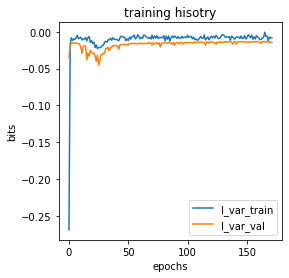

In [18]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [19]:
phi = gpmap.x_to_phi(x_test)

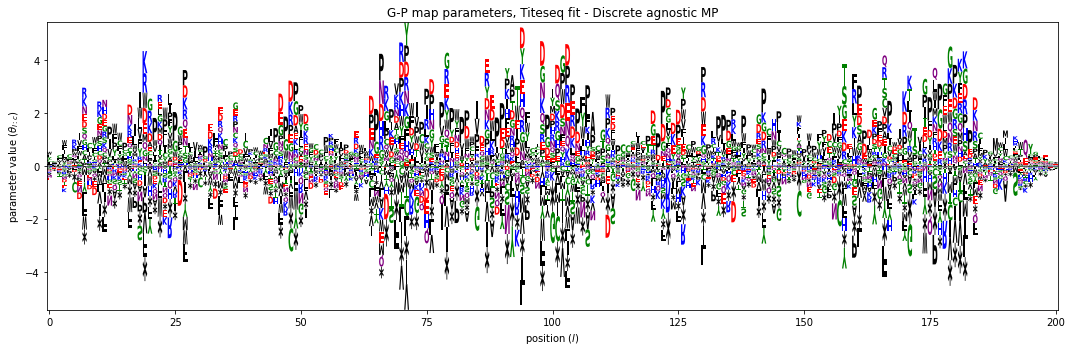

In [28]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True,color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Titeseq fit - Discrete agnostic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_titeseq_only_DA-MP.png',dpi=300,bbox_inches='tight')
plt.show()

In [21]:
np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [25]:
sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
titeseq_gpmap = np.load('titeseq_gpmap_discrete_agnostic.npy')

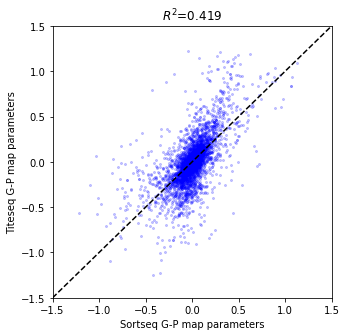

In [26]:
plt.figure(figsize=(5,5))
# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# Style plot
xlim = [-1.5, 1.5]

plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
plt.xlabel('Sortseq G-P map parameters')
plt.ylabel('Titeseq G-P map parameters')
plt.title(f'$R^2$={Rsq:.3}');
plt.plot(xlim, xlim, '--', color='k', label='diagonal')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

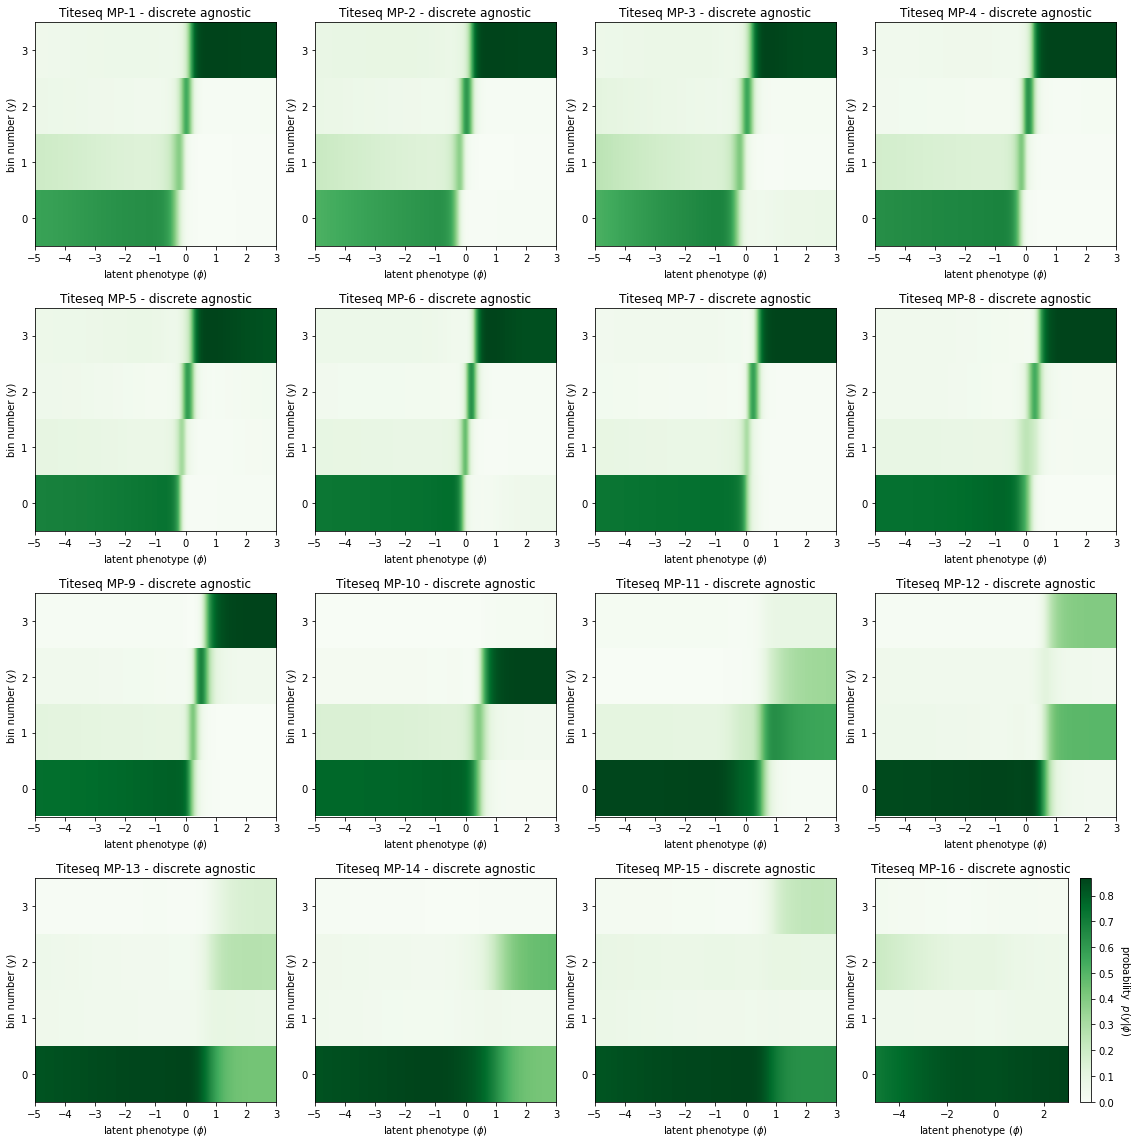

In [27]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(4,4,figsize=[16,16])

mp_counter = 0
for i in range(4):
    for j in range(4):
        
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, -phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete agnostic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('ace2rbd_mpa_measurment_prcoess_expression.png',dpi=300,bbox_inches='tight')
